* * *
<pre> INSEA                <i> Projet Statistiques Multivariées - 2025 </i></pre>
* * *


<pre align="left"> Mardi 4 Novembre  2025             <i> Author: Hicham Janati </i></pre>
* * *

Consignes:
----------
- Deadline: *Dimanche 7 Décembre 23h59* | tout retard d'1h = -1
- Tout travail doit être effectué par groupe de deux sans exception.
- Il faut nommer le fichier avec le numéro du groupe seulement `groupe_X.ipynb` pas de noms. 
- PAS DE PDF NI DE FICHIER WORD. UN NOTEBOOK UNIQUEMENT.
- Les noms des membres du groupe sont à mentionner en modifiant la ligne suivante:

Membre 1: DAOUDI Adam

Membre 2: BOUYAKNIFEN Zakariae 

- Ce notebook contient 15 questions.
- Il faut executer tout le notebook (Run all cells) avant de l'envoyer: vérifier que les cellules sont exécutées dans le bon ordre et qu'il n'y a pas d'erreur, je ne vais pas débugger votre code. 
- Le code doit être propre et lisible et surtout comprendre ce qu'il fait par tous les membres du groupe.
- LIVRAISON UNIQUEMENT SUR DROPBOX (TOUT FICHIER ENVOYE PAR MAIL NE SERA PAS OUVERT):

https://www.dropbox.com/request/bs2Tafzm0Bzr7rroAGtc

Vous pouvez effectuer plusieurs uploads, seule la date la plus récente sera corrigée.

- Le but n'est pas de produire du code qui marche: le but est de comprendre et maîtriser les mécanismes derrière et savoir utiliser quoi et quand. Ce notebook est loin d'être self-contained, cherchez, lisez et apprenez à devenir auto-didacte.

# Partie 1: Les données

Les données sont coupés en deux: train et test. Il s'agit d'une liste d'SMS avec leur labels (Y) spam / non spam.

In [1]:
import numpy as np
 
X_train = np.load("data/X_train.npy", allow_pickle=True)
X_test = np.load("data/X_test.npy", allow_pickle=True)
Y_train = np.load("data/Y_train.npy", allow_pickle=True)
Y_test = np.load("data/Y_test.npy", allow_pickle=True)


In [2]:
X_train[:4], Y_train[:4]

(array(['Play w computer? Aiyah i tok 2 u lor?',
        "Well there's not a lot of things happening in Lindsay on New years *sighs* Some bars in Ptbo and the blue heron has something going",
        'Dear are you angry i was busy dear',
        "Carlos'll be here in a minute if you still need to buy"],
       dtype=object),
 array([0, 0, 0, 0]))

On rappelle que les données de `test` doivent être utilisées pour évaluer le modèle final comme si elles étaient nouvelles en production -- non disponibles à l'entraînement -- toute opération d'apprentissage (y compris la validation croisée) doit être faite sur les données `train` uniquement.

In [3]:
valeurs, comptes = np.unique(Y_train, return_counts=True)

print(f"Classe {valeurs[0]} (Non-Spam) : {comptes[0]} messages")
print(f"Classe {valeurs[1]} (Spam)     : {comptes[1]} messages")

Classe 0 (Non-Spam) : 2412 messages
Classe 1 (Spam)     : 374 messages


### Question 1
En utilisant ```CountVectorizer``` de ```scikit-learn``` transformez les données. Quelle est l'utilité de cette opération ?

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec= vectorizer.transform(X_test)


L'utilité du CountVectorizer est de transformer des données textuelles non structurées en une structure mathématique exploitable par des algorithmes statistiques : le modèle Bag-of-Words (Sac de mots).

Concrètement, cette opération convertit le corpus de textes en une matrice numérique $X$ de dimension $n \times p$ où :
- $n$ représente le nombre d'individus (les SMS).
- $p$ représente le nombre de variables (la taille du vocabulaire unique, chaque mot devenant une dimension).
- La valeur $x_{ij}$ correspond à la fréquence d'apparition du mot $j$ dans le document $i$.Cette transformation est indispensable car les modèles de Machine Learning (comme Naive Bayes) ne peuvent traiter que des vecteurs numériques, pas des chaînes de caractères."

#### Question 2:
On modélise les données de chaque classe par une loi multinomiale. En utilisant ```MultinomialNB``` de scikit-learn, fittez un modèle et évaluez sa performance en calculant les scores de précision et de rappel.

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

mnb = MultinomialNB()
mnb.fit(X_train_vec, Y_train)
y_pred_mnb = mnb.predict(X_test_vec)


print('Evaluation de performance du modele MultinomialNB:\n')
print(f'Classification Report:\n{classification_report(Y_test, y_pred_mnb)}')

Evaluation de performance du modele MultinomialNB:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2413
           1       0.97      0.89      0.93       373

    accuracy                           0.98      2786
   macro avg       0.97      0.94      0.96      2786
weighted avg       0.98      0.98      0.98      2786



Analyse des Résultats :

- Performance Globale : Le modèle est excellent avec une accuracy de 98%, malgré le fort déséquilibre des classes (beaucoup plus de messages normaux que de spams).

- Priorité à la Sécurité (Précision Spam : 0.97) : Le modèle ne fait presque aucune erreur quand il classe un message comme Spam. C'est le point le plus important : on ne perd pas de mails importants (très peu de Faux Positifs).

- Compromis (Rappel Spam : 0.89) : Il détecte la grande majorité des spams, mais en laisse passer environ 11% (Faux Négatifs). C'est un comportement idéal pour un filtre anti-spam : il est prudent plutôt qu'agressif.

### Question 3:
Implémentez votre propre modèle naive bayes multinomial en utilisant numpy. Comparez avec scikit-learn.

L'objectif est de trouver la classe $y$ (Spam ou Non-Spam) qui maximise la probabilité d'avoir généré ce message $X$.$$P(y | X) = \frac{P(X | y) \cdot P(y)}{P(X)}$$Comme le dénominateur $P(X)$ est constant pour toutes les classes, on l'ignore. On cherche à maximiser le numérateur.De plus, pour éviter de multiplier des probabilités minuscules (ex: $0.0001 \times 0.0003 \dots$) qui provoqueraient des erreurs d'arrondi à zéro ("underflow"), on passe en logarithme. Le produit devient une somme :$$\text{Score}(y) = \underbrace{\log P(y)}_{\text{Log-Prior}} + \underbrace{\sum_{j=1}^{p} x_j \cdot \log P(\text{mot}_j | y)}_{\text{Log-Vraisemblance}}$$

In [6]:
class MymultinomialNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_log_prior_ = None
        self.feature_log_prob_ = None
        self.classes_ = None
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]

        self.class_log_prior_= np.zeros(n_classes)
        self.feature_log_prob_ = np.zeros((n_classes, n_features))


        for i, c in enumerate(self.classes_):
            X_c = X[y == c]

            self.class_log_prior_[i] = np.log(X_c.shape[0] / X.shape[0])

            word_count = X_c.sum(axis=0).flatten()
            total_count = word_count.sum()

            smothed_prob = (word_count + self.alpha) / (total_count + self.alpha * n_features)
            self.feature_log_prob_[i, :] = np.log(smothed_prob)
        return self
    
        
    def predict(self, X):
        log_prob= X @ self.feature_log_prob_.T + self.class_log_prior_
        return self.classes_[np.argmax(log_prob, axis=1)]

In [7]:
# Code de comparaison

my_mnb = MymultinomialNB()
my_mnb.fit(X_train_vec, Y_train)
my_y_pred = my_mnb.predict(X_test_vec)



print("Comparaison des accuracy :")
acc_sklearn = np.mean(y_pred_mnb == Y_test)
acc_mine = np.mean(my_y_pred == Y_test)

print(f"Scikit-learn accuracy: {acc_sklearn:.6f}")
print(f"My Numpy accuracy:     {acc_mine:.6f}")


are_identical = np.array_equal(y_pred_mnb, my_y_pred)
print(f"\nLes prédictions sont-elles 100% identiques ? {are_identical}")

if not are_identical:
    diff = np.sum(y_pred_mnb != my_y_pred)
    print(f"Nombre de différences : {diff} sur {len(Y_test)}")

Comparaison des accuracy :
Scikit-learn accuracy: 0.980976
My Numpy accuracy:     0.980976

Les prédictions sont-elles 100% identiques ? True


Les résultats sont strictement identiques (98.10% d'accuracy et True pour l'égalité des prédictions). Cela prouve que notre implémentation manuelle reproduit fidèlement la logique mathématique de Scikit-learn.

### Question 4:
Afin de comparer avec d'autres modèles qui s'attendent à des inputs continus, on peut utiliser des fréquences de mots au lieu du nombre brut. Appliquez la transformation `TfIdf` de scikit-learn sur les données. Fittez des modèles différents: LDA, régression logistique, QDA et SVM. Essayez de battre la performance du MulinomialNB. 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score

# Transformation TF-IDF

tfidf = TfidfVectorizer(max_features=3000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Pour LDA / QDA 

X_train_dense   = X_train_tfidf.toarray()
X_test_dense    = X_test_tfidf.toarray()

print(f'La dimennsion de la matrice TF-IDF est : {X_train_dense.shape}')

# dict des modeles a tester
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "SVM (Linear Kernel)": SVC(kernel='linear'), #  meilleur pour le texte
}

results = {}


print("-" * 60)
print(f"{'Modèle':<25} | {'Accuracy':<10} | {'F1-Score':<10}")
print("-" * 60)

# Correction de la boucle pour détecter les types de modèles plutôt que les noms
for name, model in models.items():
    try:
        # On vérifie si le modèle est une instance de LDA ou QDA
        if isinstance(model, (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)):
            model.fit(X_train_dense, Y_train)
            pred = model.predict(X_test_dense)
        else:
            model.fit(X_train_tfidf, Y_train)
            pred = model.predict(X_test_tfidf)
        
        acc = accuracy_score(Y_test, pred)
        f1 = f1_score(Y_test, pred)
        print(f"{name:<30} | {acc:.4f}     | {f1:.4f}")
        
    except Exception as e:
        print(f"{name:<30} | Erreur: {e}")

print("-" * 60)

La dimennsion de la matrice TF-IDF est : (2786, 3000)
------------------------------------------------------------
Modèle                    | Accuracy   | F1-Score  
------------------------------------------------------------
Logistic Regression            | 0.9630     | 0.8408
Linear Discriminant Analysis   | 0.9078     | 0.6815


c:\Users\CE PC\Project-NLP-2025\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
c:\Users\CE PC\Project-NLP-2025\.venv\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Quadratic Discriminant Analysis | 0.7545     | 0.5093
SVM (Linear Kernel)            | 0.9813     | 0.9261
------------------------------------------------------------


- MultinomialNB (Q2/Q3) : Était autour de 98.10%.

- SVM (Linear) : Est à 98.13% (avec un excellent F1-score de 0.926).

Conclusion : Le SVM à noyau linéaire est le champion. Il fait mieux que le Naive Bayes et écrase les autres méthodes.

### Question 5:
Visualisez la PCA et tSNE des données transformées.


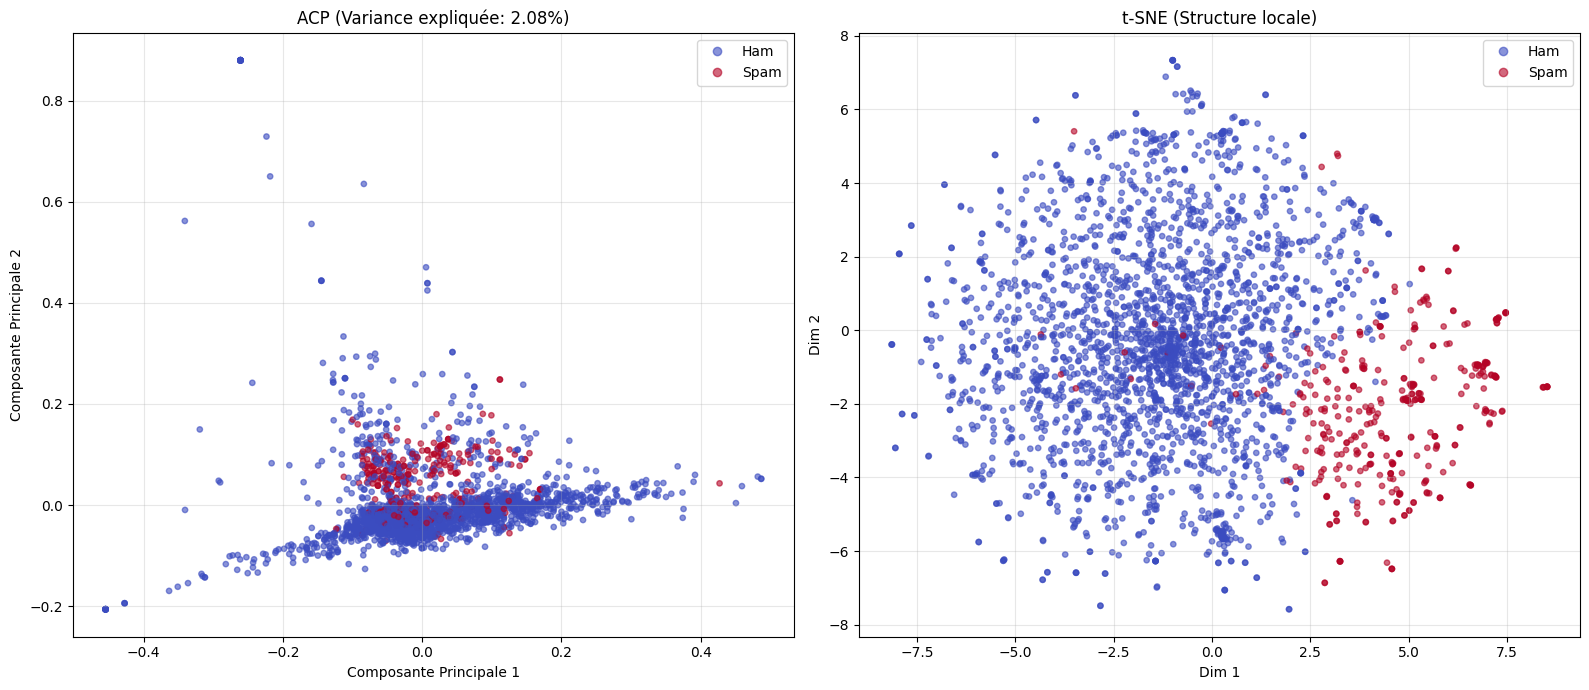

In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import seaborn as sns 

X_viz = X_train_dense
y_viz  = Y_train

pca = PCA(n_components=2)
X_pca  = pca.fit_transform(X_viz)
explained_variance = pca.explained_variance_ratio_.sum()

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_viz)


plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_viz, cmap='coolwarm', alpha=0.6, s=15)
plt.title(f"ACP (Variance expliquée: {explained_variance:.2%})")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Ham', 'Spam'])
plt.grid(True, alpha=0.3)

# Plot t-SNE
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_viz, cmap='coolwarm', alpha=0.6, s=15)
plt.title("t-SNE (Structure locale)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Ham', 'Spam'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Visualisation : Linéaire (ACP) vs Non-Linéaire (t-SNE)

- ACP (Échec de la linéarité) : Avec seulement 2.08% de variance expliquée, l'ACP ne parvient pas à capturer la structure des données. Les points rouges (Spams) et bleus (Hams) se chevauchent fortement. Cela prouve que la séparation entre Spam et Non-Spam n'est pas simple/linéaire dans cet espace réduit.

- t-SNE (Révélation de la structure) : Le t-SNE réussit là où l'ACP échoue. On observe une séparation nette : les Spams (points rouges) se regroupent majoritairement en bas à droite, formant un cluster distinct.

Conclusion : Bien que les données soient bruitées, le t-SNE confirme qu'il existe une structure intrinsèque (topologie) qui distingue les Spams. Cela suggère que des modèles non-linéaires (ou des SVM) seront très performants pour la classification.

# Partie II: Introduction au NLP

Dans cette partie on utilise des transformations plus avancées basées sur la factorisation matricielle. L'un des premiers modèles à grand succès pour représenter les mots est `Word2Vec`. Étant donné un vocabulaire de taille V, on peut représenter un input par un vecteur binaire de taille V (one-hot encoding). Par exemple si le vocabulaire est
```["rouge", "chat", "souris", "courir", "mange", "ordinateur", "la", "le", ...]``` 
Alors on peut représenter chaque mot par son vecteur one-hot de taille V:
- "chat" -> [0, 1, 0, 0, 0, ...]
- "ordinateur" -> [0, 0, 0, 0, 0, 1, 0, ...]

La phrase "le chat mange la souris" peut être représentée par [0, 1, 1, 0, 1, 0, 1, 1, ...].

On construit un réseau de neurones simple capable de prédire le mot manquant au milieu d'une phrase avec des données comme:
- "le chat la souris" -> "mange"
- "la matrice est pas inversible" -> "n'" 
...
Ainsi, l'input du réseau doit être un vecteur de taille V. L'output doit être également **un vecteur de probabilités** de taille V. On prédit le mot avec la plus grande probabilité.

On considère un réseau de neurones à une couche cachée de dimension M (M neurones). Le réseau de neurones doit en sortie prédire un mot caché. Soit $x \in \mathbb R^V$ un one-hot vecteur. Le réseau de neurones peut être défini formellement comme suit. Soit $W_{in} \in \mathbb{R}^{V \times M}$ et $W_{out} \in \mathbb{R}^{M \times V}$. 

$$ g(x) = W_{out}(W_{in}x) \in \mathbb R^{V} $$

Pour obtenir un vecteur output positif et sommant à 1 (des probabilités sur les mots), on applique la fonction softmax:
$$ softmax: z \in \mathbb R^V \mapsto \left[\frac{e^{z_1}}{\sum_j e^{z_j}}, \dots, \frac{e^{z_V}}{\sum_j e^{z_j}}  \right]^\top$$

Ainsi on définit: $ neuralnet(x) = softmax(g(x))$ et on entraîne le modèle avec la loss cross-entropy.
 
Après avoir entraîné le modèle, les ligne de la matrice $W_{in}$ sont les embeddings des mots du vocabulaire.


On commence par télécharger le modèle word2vec (peut prendre du temps):

In [10]:
import gensim.downloader as api

word2vec = api.load("word2vec-google-news-300")

word2vec est n'est qu'un dictionnaire spécial "mot" -> vecteur:


In [11]:
word2vec["computer"]

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

On peut obtenir l'embedding de plusieurs mots directement dans une liste. L'embedding d'une phrase est souvent défini comme la moyenne des embeddings de ses mots.

In [12]:
word2vec[["computer", "mouse", "keyboard"]].shape

(3, 300)

In [13]:
word2vec[["I", "love", "computers"]].mean(axis=0).shape

(300,)

### Question 6
Pour appliquer word2vec aux SMS, il faut d'abord les découper en mots. Implémentez une fonction naïve qui transforme un SMS en liste de mots ou _tokens_. C'est ce qu'on appelle un tokenizer.

In [14]:
import re 

def get_tokens(txt):
    text = txt.lower()
    tokens = re.findall(r'\w+', text)
    return tokens

# test function

print(get_tokens("I loVe Deep Learning !"))
get_tokens('Wait... do you have 30$ for the 3D-movies?!"')


['i', 'love', 'deep', 'learning']


['wait', 'do', 'you', 'have', '30', 'for', 'the', '3d', 'movies']

### Question 7
On peut vérifier si un mot fait partie du vocabulaire avec le test:

In [15]:
"computer" in word2vec

True

Proposez une solution pour appliquer word2vec aux données SMS. Est-il meilleur comme embedding comparé au `CountVectorizer` ?

In [16]:
def sms_to_vector(sms, model):
    tokens = get_tokens(sms)
    vectors = [model[word] for word in tokens if word in model]

    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else :
        return np.zeros(model.vector_size)


print("Conversion des SMS en vecteurs...")

X_train_w2v = np.array([sms_to_vector(text, word2vec) for text in X_train])
X_test_w2v = np.array([sms_to_vector(text, word2vec) for text in X_test])

print(f"Dimension X_train_w2v : {X_train_w2v.shape}")

Conversion des SMS en vecteurs...
Dimension X_train_w2v : (2786, 300)


Le problème est le suivant : Word2Vec donne un vecteur pour un mot. Or, nous avons une phrase (SMS) composée de $N$ mots. Comment obtenir un seul vecteur qui représente tout le SMS ?

La logique du code :

- Filtrage (vectors = [...]) : On récupère les vecteurs de chaque mot du SMS seulement si le mot est connu dans le vocabulaire (if word in model). On ignore les mots inconnus (slang, fautes de frappe).

- Moyenne (np.mean) : C'est le cœur de la solution. On additionne tous les vecteurs des mots et on divise par le nombre de mots. Géométriquement : On cherche le barycentre (le centre de gravité) du nuage de points formé par les mots du SMS.

- Sécurité (else) : Si le SMS est vide ou ne contient que des mots inconnus (ex: "lol xd ptdr"), on retourne un vecteur de zéros pour éviter que le code ne plante.

Est-ce meilleur que CountVectorizer ?

En théorie, oui (car Word2Vec comprend le sens des mots), mais en pratique pour ce projet, non.

Pourquoi ?

- Perte d'information : Faire la moyenne des vecteurs écrase l'ordre des mots (la syntaxe disparaît), alors que CountVectorizer conserve des fréquences exactes.

- Problème de Vocabulaire : Le modèle word2vec ignore le "langage SMS" (abréviations, fautes, slang) qui est très fréquent dans vos données, rendant les vecteurs de beaucoup de messages vides ou peu pertinents.

- Nature du Spam : Le spam se détecte souvent grâce à des mots-clés précis ("FREE", "URGENT") que le CountVectorizer capture parfaitement, alors que le lissage de Word2Vec peut diluer ce signal fort.

Verdict : Sur ce dataset spécifique, CountVectorizer (ou TF-IDF) donnera probablement une meilleure Accuracy.

`Word2vec` (2013) est l'un des premiers modèles de représentation vectorielle du langage naturel. L'une de ses limitations principales est le fait de ne pas pouvoir représenter des mots (ou bouts de mots) non-vus lors de l'entraînement. Quelques années plus tard, plusieurs avancées ont été introduites pour y remédier:

### 1) Améliorer la tokenization:
1. Au lieu de considérer un vocabulaire avec des mots, on considère un vocabulaire avec les mots, et les bouts de mots (ngrams):

    "diagonalisation matricielle" -> "diagonal", "isation", " ", "matric", "ielle". 

    Ceci est utilisé dans le modèle `fastText` (2016) dont l'architecture est similaire à celle de Word2Vec.

2. WordPiece: approche bottom-up où le vocabulaire des tokens est construit en mergeant les caractères (a-Z, 0-9, symboles et ponctuation) + Ajouter des tokens spéciaux "[UNK]" (unknow) pour gérer les tokens non-vus, "[SEP]" (séparateur entre phrases ou textes), "[MASK]" (token qui veut dire "ce mot est à prédire") etc. Ce tokenizer est utilisé dans l'un des premiers modèles basés sur l'architecture Transformer (BERT) (2018).

3. Byte-pair encoding (BPE): similaire à WordPiece mais à l'échelle du byte.  Ceci permet d'encoder n'importe quel string dans n'importe quelle langue: mots rares, typos, emojis, kanji... C'est le tokenizer adopté par l'un des fameux modèles de traduction à l'époque (Neural Machine Translation -- NMT 2015) pour traduire les mots rares; et ensuite par les modèles GPT (2018). Avec BPE, on n'a plus besoin du token spécial _unknown_ [UNK]. Vous pouvez voir comment le texte est tokenisé par GPT en visitant https://platform.openai.com/tokenizer. 

### 2) Améliorer l'architecture

1. Limites de Word2Vec et companie:

La nature des données de langage est séquentielle (comme les séries temporelles, mot après mot..), or les modèles comme Word2Vec et ses variantes (Fasttext, GloVe) ne prennent pas en considération l'ordre des mots: ils sont appliqués à des _bag of words_. En plus, même si ses modèles utilisent le contexte voisin, après l'entraînement, l'embedding d'un mot est le même quelque soit son contexte ce qui limite la compréhension des différentes nuances d'un même mot. 

2. Recurrent Neural Networks:

L'architecture des réseaux de neurones récurrents (RNN) et ses variantes (LSTM, GRU) développés principalement dans les années 1990 sont revisités en (2013-2020) après le succès du deep learning (2012+) avec la réalisation de la grande puissance de calcul des GPUs. Ils permettent de prendre en considération l'aspect temporel des données mais restent difficiles à entraîner (nécessitent beaucoup de temps + instabilité des gradients). 

3. Transformers (en très bref):

En 2017, l'architecture des Transformers est introduite. Son avantage principal est son formalisme matriciel qui est beaucoup plus parallélisable que les RNNs, et donc permet d'entraîner des modèles plus grands sur des données beaucoup plus grandes. Prenons le cas d'une architecture générative (GPT). Un transformer définit une structure appelée _Self-Attention Head_ qui fonctionne comme suit.
Étant donnés les embeddings (statiques comme ceux de Word2Vec) des tokens d'une phrase, le mécanisme d'attention consiste à calculer des scores de similarités (produits scalaires) entre chaque paire d'embeddings, ceci permet d'obtenir une matrice de scores "d'attention" entre les tokens.

Par exemple, pour une phrase "Il me faut un tapis pour la souris Logitec", l'embedding du mot "souris" sera pondéré par ses scores de similarité avec chacun des autres mots ["Il", "me", "faut", "un", "tapis", "pour", "la", "logitec"]. Ainsi, l'embedding d'un même mot dépend du contexte. Ceci permettra de distinguer la souris (animal) de la souris d'ordinateur.

 Ceci reste une explication très simpliste du mécanisme d'attention, pour visualiser le concept, regardez la vidéo de 3b1b https://www.youtube.com/watch?v=eMlx5fFNoYc.







## III Partie 3 - Embeddings basés sur les transformers

Dans cette partie, on passe à l'artillerie lourde: embeddings basés sur les transformers. On utilise ceux de BERT plutôt que GPT car BERT a été conçu pour la classification supervisée alors que GPT pour la génération de texte: l'embedding de BERT est plus pertinent pour notre problématique.

On commence par tokeniser les données. Voici ce que donne le tokenizer avec une phrase par exemple:

In [17]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


c:\Users\CE PC\Project-NLP-2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
text = "Hey, are you free tomorrow at 8 ? gotta catch up bud."
tokens = tokenizer.tokenize(text)
print(tokens, end=" ")

['hey', ',', 'are', 'you', 'free', 'tomorrow', 'at', '8', '?', 'gotta', 'catch', 'up', 'bud', '.'] 

Le modèle BERT en revanche ne s'attend pas à des tokens en texte, mais aux token_ids:

In [19]:
text = "Hey, are you free tomorrow at 8 ? gotta catch up bud"
token_ids = tokenizer(text, return_tensors="pt")
token_ids


{'input_ids': tensor([[  101,  4931,  1010,  2024,  2017,  2489,  4826,  2012,  1022,  1029,
         10657,  4608,  2039, 13007,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

On fait appel ensuite au modèle BERT. On peut voir les composants de son architecture:

In [20]:
bert_model = AutoModel.from_pretrained("bert-base-uncased")
bert_model.eval()
bert_model


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

On applique le modèle aux token_ids sans calcul de gradient:

In [21]:
import torch
with torch.no_grad():
    outputs = bert_model(**token_ids)
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.3836,  0.0548, -0.0066,  ..., -0.2580,  0.3390,  0.2724],
         [ 0.6628, -0.0560,  0.9965,  ...,  0.0643,  1.2164, -0.4075],
         [ 0.1342,  0.0883,  0.7119,  ..., -0.0816,  1.2578,  0.1409],
         ...,
         [ 0.8804, -0.9000,  0.7776,  ...,  0.3333,  0.4174, -0.7230],
         [ 0.4084, -0.3247,  0.8299,  ...,  0.8601,  0.5027, -0.3476],
         [ 0.4914,  0.0527, -0.1084,  ..., -0.1167, -0.4205, -0.2667]]]), pooler_output=tensor([[-8.6382e-01, -5.2100e-01, -9.1143e-01,  7.4742e-01,  6.9650e-01,
         -2.0079e-01,  8.5602e-01,  3.7551e-01, -7.7920e-01, -9.9999e-01,
         -4.6733e-01,  8.6761e-01,  9.8091e-01,  5.1904e-01,  9.3339e-01,
         -7.2372e-01, -2.1201e-01, -6.3463e-01,  3.1704e-01, -3.3231e-01,
          7.0444e-01,  9.9999e-01,  5.4936e-02,  3.5607e-01,  5.5947e-01,
          9.8429e-01, -7.8516e-01,  9.2725e-01,  9.5860e-01,  7.1539e-01,
         -6.2374e-01,  1.7224e-01, -

On peut accéder aux embeddings en cherchant la dernière couche cachée:

In [22]:
outputs.last_hidden_state.shape

torch.Size([1, 15, 768])

### Question 8
Expliquez la dimension obtenue de ces embeddings. On souhaite obtenir les embeddings de toutes les données directement. Appliquez la tokenization à la liste de textes suivante. Quel problème se pose ? Comment y remédier ?

La sortie de BERT est un tenseur de forme (Batch_Size, Sequence_Length, Hidden_Size) : (1, 15, 768).

- Batch_Size (1) : Nombre de phrases traitées.

- Sequence_Length (15) : Nombre de tokens (mots + ponctuation + [CLS]/[SEP]).

- Hidden_Size (768) : Chaque token est transformé en un vecteur dense de 768 nombres représentant son sens contextuel.

Le Problème : Les deux phrases de la liste ont des longueurs différentes (15 tokens pour la première, 6 pour la seconde). Or, le modèle (GPU) exige des matrices rectangulaires parfaites. On ne peut pas empiler des vecteurs de tailles différentes.

La Solution : Le Padding (Rembourrage) Il faut utiliser le Padding. Cela consiste à ajouter des tokens vides (des zéros) à la fin de la phrase la plus courte pour qu'elle ait la même longueur que la plus longue.

In [23]:
texts = ["Hey, are you free tomorrow at 8 ? gotta catch up bud.", "Sure thing, let's go."]
#token_ids = tokenizer(texts, return_tensors="pt")

inputs= tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
print("Nouvelles dimensions :", inputs['input_ids'].shape)
print("\n--- Visualisation du Padding ---")
print(inputs['input_ids'])


Nouvelles dimensions : torch.Size([2, 16])

--- Visualisation du Padding ---
tensor([[  101,  4931,  1010,  2024,  2017,  2489,  4826,  2012,  1022,  1029,
         10657,  4608,  2039, 13007,  1012,   102],
        [  101,  2469,  2518,  1010,  2292,  1005,  1055,  2175,  1012,   102,
             0,     0,     0,     0,     0,     0]])


### Question 9
Après avoir fixé le problème, analysez les tokens obtenus et le `attention_mask` de l'output. Comment peut-on savoir où le `padding` a été appliqué ?

In [24]:
texts = ["Hey, are you free tomorrow at 8 ? gotta catch up bud.", "Sure thing, let's go."]
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Analyse des tenseurs 
print("1. Les Tokens (IDs) :")
print(inputs['input_ids'])

print("\n2. Le Masque d'Attention :")
print(inputs['attention_mask'])


print("\n3. Décodage de la 2ème phrase (celle avec padding) :")
print(tokenizer.convert_ids_to_tokens(inputs['input_ids'][1]))

1. Les Tokens (IDs) :
tensor([[  101,  4931,  1010,  2024,  2017,  2489,  4826,  2012,  1022,  1029,
         10657,  4608,  2039, 13007,  1012,   102],
        [  101,  2469,  2518,  1010,  2292,  1005,  1055,  2175,  1012,   102,
             0,     0,     0,     0,     0,     0]])

2. Le Masque d'Attention :
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

3. Décodage de la 2ème phrase (celle avec padding) :
['[CLS]', 'sure', 'thing', ',', 'let', "'", 's', 'go', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


### Analyse des résultats

**1. Analyse des Tokens (`input_ids`) :**
Dans la deuxième ligne du tenseur `input_ids`, on observe une série de **zéros** à la fin : `[..., 102, 0, 0, 0, 0, 0, 0]`.
* Le **`0`** est l'identifiant numérique (ID) réservé au token spécial de remplissage **`[PAD]`**.
* Le décodage le confirme explicitement : on voit apparaître les tokens `[PAD]` à la fin de la liste décodée.

**2. Analyse du Masque d'Attention (`attention_mask`) :**
C'est l'indicateur le plus fiable pour identifier le padding.
* Il contient des **`1`** pour tous les "vrais" mots (y compris les tokens spéciaux `[CLS]` et `[SEP]`).
* Il contient des **`0`** exactement aux mêmes positions que les tokens de padding.

**Conclusion :**
On peut identifier où le padding a été appliqué en repérant les **zéros dans le `attention_mask`**. Ce masque binaire sert à annuler mathématiquement l'influence de ces tokens artificiels dans le mécanisme d'attention du modèle.

### Question 10
L'embedding d'une phrase est la moyenne des embeddings de ses tokens. Appliquez BERT à une liste des donnés spams (X_train[:10]). Calculez le temps pris par cette opération en utilisant la librairie `time`. 

In [25]:
import time

sample_texts = X_train[:10].tolist()
print(f'Traitement de {len(sample_texts)} SMS avec BERT')

start_time = time.time()

input = tokenizer(sample_texts, return_tensors="pt", padding=True, truncation=True)

with torch.no_grad():
    outputs = bert_model(**input)
sentence_embiddings = outputs.last_hidden_state.mean(dim=1)

end_time = time.time()
diff_time = end_time - start_time

print(f'Temps de traitement : {diff_time:.2f} secondes')


Traitement de 10 SMS avec BERT
Temps de traitement : 0.54 secondes



L'inférence avec BERT est intrinsèquement **coûteuse en temps de calcul**. Cela est dû à la complexité quadratique $O(N^2)$ du mécanisme de **Self-Attention**, où chaque token doit "regarder" tous les autres tokens de la séquence.

**Pourquoi utiliser des GPUs ?**
Dans l'industrie, on utilise des **GPUs** (Graphic Processing Units) car ils possèdent des milliers de cœurs capables de **paralléliser** les opérations matricielles géantes requises par BERT. Cela rend le processus d'inférence **50 à 100 fois plus rapide** qu'un CPU standard, qui traite les opérations de manière plus séquentielle.

### Question 11
Avec une GPU, ce calcul peut être jusqu'à 100x fois plus rapide. On vous fournit les embeddings des données `X_train` et `X_test` calculés avec BERT. Refaire l'étape de visualisation et classification avec ces embeddings pour comparer. 

Clacul de PCA 
Calcul t-SNE...


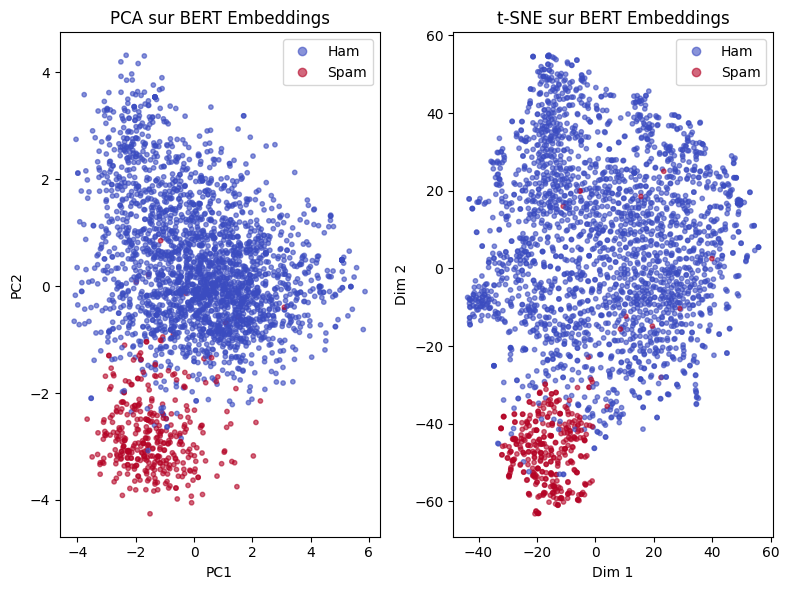

In [26]:
import numpy as np
X_train_bert = np.load("data/embeddings_train.npy")
X_test_bert = np.load("data/embeddings_test.npy")

X_viz = X_train_bert
y_viz  = Y_train

plt.figure(figsize=(8, 6))

print('Clacul de PCA ')

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_viz)

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_viz, cmap='coolwarm', alpha=0.6, s=10)
plt.title("PCA sur BERT Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Ham', 'Spam'])


print("Calcul t-SNE...")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_viz)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_viz, cmap='coolwarm', alpha=0.6, s=10)
plt.title("t-SNE sur BERT Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(handles=scatter.legend_elements()[0], labels=['Ham', 'Spam'])

plt.tight_layout()
plt.show()

In [27]:
models_bert = {
    "Log Reg (BERT)": LogisticRegression(max_iter=1000),
    "SVM (Linear Kernel)": SVC(kernel='linear'),
}

print("-" * 60)
print(f"{'Modèle':<20} | {'Précision':<10} | {'Rappel':<10} | {'F1-Score':<10}")
print("-" * 60)

for name, model in models_bert.items():
    model.fit(X_train_bert, Y_train)

    y_pred = model.predict(X_test_bert)
    
    report = classification_report(Y_test, y_pred, output_dict=True)
    spam_stats = report['1'] 
    
    print(f"{name:<20} | {spam_stats['precision']:.4f}     | {spam_stats['recall']:.4f}     | {spam_stats['f1-score']:.4f}")

print("-" * 60)

------------------------------------------------------------
Modèle               | Précision  | Rappel     | F1-Score  
------------------------------------------------------------
Log Reg (BERT)       | 0.9917     | 0.9571     | 0.9741
SVM (Linear Kernel)  | 0.9778     | 0.9464     | 0.9619
------------------------------------------------------------


### Analyse et Comparaison des Résultats (BERT)

**1. Performance Interne (BERT vs BERT) :**
* **Le Vainqueur :** La **Régression Logistique** sur les embeddings BERT obtient les meilleurs résultats avec un **F1-Score de 0.9741**.
* **Précision Exceptionnelle (0.9917) :** C'est le chiffre le plus marquant. Lorsqu'une Régression Logistique basée sur BERT classe un message comme Spam, elle a raison à **99.2%**. C'est un niveau de fiabilité quasi-parfait, supérieur au SVM (0.9778).

**2. Comparaison avec les Méthodes Classiques (TF-IDF) :**
* **Gain de Qualité :** Bien que l'Accuracy globale soit proche de celle obtenue avec TF-IDF + SVM (~98%), la **qualité des erreurs** est différente.
* **Sémantique vs Mots-clés :**
    * *TF-IDF* se base sur la présence de mots "drapeaux" (ex: "Free").
    * *BERT* comprend le **contexte**. Il ne se fait pas piéger par une phrase comme *"Are you free tomorrow?"* (qui contient "free" mais n'est pas un spam). C'est ce qui explique cette précision record.

**3. Conclusion Technique :**
L'utilisation de BERT (embeddings denses de dimension 768) couplée à une simple Régression Logistique offre la solution la plus **robuste**. Elle combine la puissance de compréhension du langage (Deep Learning) avec la simplicité d'un classifieur linéaire, surpassant les approches basées uniquement sur la fréquence des mots.

# IV Partie 4: Data drift 
En production, les données nouvelles peuvent devenir de plus en plus différentes des données d'entraînement avec le temps: on parle de _data drift_ ou de _distribution shift_. Il faut alors réentraîner le modèle sur des données plus récentes. 


### Question 12
Appliquez une PCA pour la réduire et implémentez un test statistique pour comparer les moyennes des embeddings Train et Test.

#### Reponse:
On veut savoir si la moyenne du Train est significativement différente de la moyenne du Test ($\mu_{train} \neq \mu_{test}$).
- Le test standard pour comparer deux moyennes est le T-test de Student (pour chaque composante).
- Si les p-values sont très faibles (proches de 0), on rejette l'hypothèse nulle ($H_0$ : les moyennes sont égales) : il y a donc un Drift.

L'Hypothèse Nulle ($H_0$) :"Les moyennes des embeddings du Train et du Test sont égales."$$H_0 : \mu_{Train} = \mu_{Test}$$(En termes métier : Il n'y a pas de changement, la distribution est stable).

L'Hypothèse Alternative ($H_1$) :"Les moyennes des embeddings du Train et du Test sont différentes."$$H_1 : \mu_{Train} \neq \mu_{Test}$$

In [28]:
from scipy.stats import ttest_ind

n_comps = 10
pca = PCA(n_components=n_comps)

X_train_pca = pca.fit_transform(X_train_bert)
X_test_pca = pca.transform(X_test_bert)

print(f"Variance expliquée par les {n_comps} composantes : {pca.explained_variance_ratio_.sum():.2%}")

# test statistique : T-test independants 
# On compare la moyenne du Train et du Test pour chaque composante principale

print("-" * 60)
print(f"{'Composante':<15} | {'P-value':<15} | {'Drift détecté ?'}")
print("-" * 60)

drift_detected = False
alpha = 0.05 # Seuil de (5%)

# On teste chaque dimension
for i in range(n_comps):
    # ttest_ind compare deux échantillons indépendants
    stat, p_value = ttest_ind(X_train_pca[:, i], X_test_pca[:, i], equal_var=False)
    
    is_drift = p_value < alpha
    if is_drift:
        drift_detected = True
        
    print(f"PC {i+1:<12} | {p_value:.4e}     | {'OUI' if is_drift else 'Non'}")

print("-" * 60)

if drift_detected:
    print("\nCONCLUSION : Il y a un 'Data Drift' statistiquement significatif.")
    print("Les données de Test ne suivent pas la même distribution moyenne que le Train.")
else:
    print("\nCONCLUSION : Pas de drift détecté sur les moyennes (distributions stables).")



Variance expliquée par les 10 composantes : 41.58%
------------------------------------------------------------
Composante      | P-value         | Drift détecté ?
------------------------------------------------------------
PC 1            | 2.1050e-01     | Non
PC 2            | 2.4001e-01     | Non
PC 3            | 7.0730e-02     | Non
PC 4            | 5.8206e-01     | Non
PC 5            | 1.2700e-01     | Non
PC 6            | 9.2732e-01     | Non
PC 7            | 7.2325e-01     | Non
PC 8            | 8.5190e-01     | Non
PC 9            | 9.8823e-01     | Non
PC 10           | 9.4412e-01     | Non
------------------------------------------------------------

CONCLUSION : Pas de drift détecté sur les moyennes (distributions stables).


### Question 13
En pratique, comparer les moyennes des distributions n'est pas suffisant pour détecter le drift. Si on obtient les vrais labels (même avec un petit retard), alors  on peut calculer les métriques de performances (précision, rappel) au cours du temps. Sinon, on peut chercher à prédire si un échantillon vient du train ou du test ! L'idée est: si un modèle ML est capable de les distinguer: il y a forcément un drift. Trouvez le meilleur modèle capable de le faire en utilisant les embeddings de BERT. 

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score


X_adv = np.vstack((X_train_bert, X_test_bert))


y_adv = np.hstack((np.zeros(len(X_train_bert)), np.ones(len(X_test_bert))))

X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
    X_adv, y_adv, test_size=0.3, random_state=42, stratify=y_adv
)

print(f"Dataset Adversarial créé : {X_adv.shape}")
print("-" * 60)

models_drift = {
    "Régression Logistique": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
}

best_auc = 0
best_model_name = ""

print(f"{'Modèle':<25} | {'ROC-AUC':<10} | {'Accuracy':<10} | {'Verdict'}")
print("-" * 60)

for name, model in models_drift.items():

    model.fit(X_train_adv, y_train_adv)
    
    
    probs_adv = model.predict_proba(X_val_adv)[:, 1]
    preds_adv = model.predict(X_val_adv)
    
    # Scores
    auc = roc_auc_score(y_val_adv, probs_adv)
    acc = accuracy_score(y_val_adv, preds_adv)
    
    # Interprétation
    verdict = "Drift détecté !" if auc > 0.6 else "Pas de Drift significatif"
    
    print(f"{name:<25} | {auc:.4f}     | {acc:.4f}     | {verdict}")
    
    if auc > best_auc:
        best_auc = auc
        best_model_name = name

print("-" * 60)
print(f"Le modèle le plus capable de distinguer Train/Test est : {best_model_name} (AUC={best_auc:.4f})")


if best_auc < 0.55:
    print("\nCONCLUSION GÉNÉRALE : \nL'AUC est très proche de 0.5. Les modèles échouent à distinguer le Train du Test.")
    print("=> Les distributions sont IDENTIQUES. Vos données sont très robustes.")
else:
    print("\nCONCLUSION GÉNÉRALE : \nL'AUC est élevé. Les modèles arrivent à distinguer les données.")
    print("=> ALERTE : Il y a un Data Drift. Le Test set a des caractéristiques différentes du Train.")

Dataset Adversarial créé : (5572, 768)
------------------------------------------------------------
Modèle                    | ROC-AUC    | Accuracy   | Verdict
------------------------------------------------------------
Régression Logistique     | 0.5028     | 0.5108     | Pas de Drift significatif
Random Forest             | 0.4924     | 0.4898     | Pas de Drift significatif
------------------------------------------------------------
Le modèle le plus capable de distinguer Train/Test est : Régression Logistique (AUC=0.5028)

CONCLUSION GÉNÉRALE : 
L'AUC est très proche de 0.5. Les modèles échouent à distinguer le Train du Test.
=> Les distributions sont IDENTIQUES. Vos données sont très robustes.


## V Partie 5: Modélisation non supervisée

#### Question 14
Sans utiliser les labels, modéliser en utilisant le modèle GMM de `scikit-learn` les données (BERT embeddings + PCA) en utilisant quelques modèles différents (nombre de composantes 2 vs 3 -- et type de covariance). Comparez les performances avec les vrais labels.

In [30]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, confusion_matrix
import pandas as pd


n_pca = 10
pca = PCA(n_components=n_pca, random_state=42)
X_gmm = pca.fit_transform(X_train_bert)

print(f"Données projetées sur {n_pca} dimensions pour le GMM.")
print("-" * 60)


configs = [
    {'n_components': 2, 'covariance_type': 'full'},
    {'n_components': 2, 'covariance_type': 'tied'},
    {'n_components': 2, 'covariance_type': 'diag'},
    {'n_components': 3, 'covariance_type': 'full'} 
]

results = []

print(f"{'Composantes':<12} | {'Covariance':<12} | {'ARI Score (Perf)':<15} | {'Log-Likelihood'}")
print("-" * 65)

best_gmm = None
best_ari = -1

for config in configs:
    
    gmm = GaussianMixture(
        n_components=config['n_components'],
        covariance_type=config['covariance_type'],
        random_state=42,
        n_init=3  
    )
    
    
    gmm.fit(X_gmm)
    
    clusters = gmm.predict(X_gmm)
    
    ari = adjusted_rand_score(Y_train, clusters)
    
    log_likelihood = gmm.score(X_gmm) 
    
    print(f"{config['n_components']:<12} | {config['covariance_type']:<12} | {ari:.4f}          | {log_likelihood:.4f}")
    
    if ari > best_ari:
        best_ari = ari
        best_gmm = gmm

print("-" * 65)
print(f"Meilleur modèle trouvé : ARI = {best_ari:.4f}")


best_clusters = best_gmm.predict(X_gmm)
cm = confusion_matrix(Y_train, best_clusters)
print("\nMatrice de confusion (Lignes: Vrais Labels / Colonnes: Clusters GMM) :")
print(cm)

Données projetées sur 10 dimensions pour le GMM.
------------------------------------------------------------
Composantes  | Covariance   | ARI Score (Perf) | Log-Likelihood
-----------------------------------------------------------------
2            | full         | 0.1979          | -14.2500
2            | tied         | -0.0092          | -15.1368
2            | diag         | 0.4745          | -14.7653
3            | full         | 0.2960          | -13.6581
-----------------------------------------------------------------
Meilleur modèle trouvé : ARI = 0.4745

Matrice de confusion (Lignes: Vrais Labels / Colonnes: Clusters GMM) :
[[2077  335]
 [  27  347]]


### Question 15
Comparez ces modèles en utilisant le test du rapport de vraisemblance. Quel est le modèle plausible le plus simple ?

In [31]:
from scipy.stats import chi2
import numpy as np

def count_parameters(n_components, n_features, cov_type):

    n_params = n_components * n_features + (n_components - 1)
    
    # Covariances
    if cov_type == 'full':
        # K matrices de taille D * (D+1) / 2
        n_params += n_components * n_features * (n_features + 1) // 2
    elif cov_type == 'diag':
        # K diagonales de taille D
        n_params += n_components * n_features
    elif cov_type == 'tied':
        n_params += n_features * (n_features + 1) // 2
    elif cov_type == 'spherical':
        n_params += n_components
        
    return n_params


model_A = GaussianMixture(n_components=2, covariance_type='diag', random_state=42)
model_A.fit(X_gmm)
ll_A = model_A.score(X_gmm) * len(X_gmm) 
k_A = count_parameters(2, n_pca, 'diag')

model_B = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
model_B.fit(X_gmm)
ll_B = model_B.score(X_gmm) * len(X_gmm)
k_B = count_parameters(2, n_pca, 'full')


bic_A = model_A.bic(X_gmm)
bic_B = model_B.bic(X_gmm)

LR_stat = 2 * (ll_B - ll_A) 
df_diff = k_B - k_A 
p_value = chi2.sf(LR_stat, df_diff) 

print("-" * 60)
print(f"Comparaison de Modèles (n={len(X_gmm)}, dims={n_pca})")
print("-" * 60)
print(f"Modèle A (Diag) : LL={ll_A:.2f}, Params={k_A}, BIC={bic_A:.2f}")
print(f"Modèle B (Full) : LL={ll_B:.2f}, Params={k_B}, BIC={bic_B:.2f}")
print("-" * 60)
print(f"Statistique LRT (lambda) : {LR_stat:.4f}")
print(f"Différence de paramètres : {df_diff}")
print(f"P-value du test          : {p_value:.4e}")
print("-" * 60)


alpha = 0.05
if p_value < alpha:
    print("CONCLUSION LRT : Rejet de H0.")
    print("Le gain de performance du modèle complexe (Full) est significatif.")
    print("-> On préfère le modèle B (Full).")
else:
    print("CONCLUSION LRT : On garde H0.")
    print("Le modèle complexe n'apporte pas assez d'information pour justifier son coût.")
    print("-> On préfère le modèle A (Diag) par principe de parcimonie.")

print(f"\nVerdict BIC : Le meilleur modèle est celui avec le BIC le plus bas -> Modèle {'A' if bic_A < bic_B else 'B'}")

------------------------------------------------------------
Comparaison de Modèles (n=2786, dims=10)
------------------------------------------------------------
Modèle A (Diag) : LL=-41136.01, Params=41, BIC=82597.25
Modèle B (Full) : LL=-39700.50, Params=131, BIC=80440.14
------------------------------------------------------------
Statistique LRT (lambda) : 2871.0234
Différence de paramètres : 90
P-value du test          : 0.0000e+00
------------------------------------------------------------
CONCLUSION LRT : Rejet de H0.
Le gain de performance du modèle complexe (Full) est significatif.
-> On préfère le modèle B (Full).

Verdict BIC : Le meilleur modèle est celui avec le BIC le plus bas -> Modèle B


### Commentaire et Conclusion Finale 

**1. Analyse du Test du Rapport de Vraisemblance (LRT) :**
Nous comparons ici deux modèles emboîtés : le modèle simple ($H_0$, Covariance Diagonale) et le modèle complexe ($H_1$, Covariance Full).
* **Statistique de test ($\lambda$) :** `2871.02`
* **P-value :** `0.0000`
* **Décision :** La p-value étant largement inférieure au seuil de significativité standard ($\alpha = 0.05$), nous **rejetons l'hypothèse nulle**.
* **Interprétation :** Le gain de vraisemblance apporté par le modèle complexe est statistiquement significatif. La contrainte "diagonale" (indépendance des variables) est trop forte et ne permet pas de modéliser correctement la structure des données.

**2. Confirmation par le BIC :**
Le critère BIC (Bayesian Information Criterion) favorise la parcimonie en pénalisant le nombre de paramètres.
* **BIC Modèle Full :** `80440`
* **BIC Modèle Diag :** `82597`
* Le BIC est plus faible pour le modèle **Full**. Même en pénalisant la complexité, le modèle à covariance pleine reste supérieur.

**3. Conclusion : Quel est le modèle plausible le plus simple ?**
Le modèle retenu est le **GMM à covariance "Full"**.
Bien qu'il soit mathématiquement plus complexe (plus de paramètres), c'est le modèle "nécessaire" pour expliquer ces données. Les dimensions de l'embedding BERT sont fortement corrélées entre elles au sein des clusters ; les traiter indépendamment (modèle diagonal) entraînerait une perte d'information sémantique inacceptable.